In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, precision_recall_curve
)
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)
pd.set_option('display.max_columns', None)

In [2]:
def preprocess_dates(df):
    df = df.copy()
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        
        df['App_Year'] = df['ApplicationDate'].dt.year.fillna(0).astype(int)
        df['App_Month'] = df['ApplicationDate'].dt.month.fillna(0).astype(int)
        
        df = df.drop('ApplicationDate', axis=1)
    return df

try:
    train_df = pd.read_csv('train_c.csv')
    test_df = pd.read_csv('test_c.csv')
    print(f"Данные загружены. Train: {train_df.shape}, Test: {test_df.shape}")
except FileNotFoundError:
    print("Файлы не найдены. Генерируем синтетические данные для демонстрации работы кода.")
    cols = [
        'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 
        'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 
        'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 
        'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 
        'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 
        'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 
        'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 
        'MonthlyLoanPayment', 'TotalDebtToIncomeRatio'
    ]
    train_df = pd.DataFrame(np.random.rand(500, len(cols)), columns=cols)
    train_df['ID'] = range(500)
    train_df['ApplicationDate'] = '2023-01-01'
    train_df['Loan Approved'] = np.random.randint(0, 2, 500)
    cat_cols_mock = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
    for c in cat_cols_mock:
        train_df[c] = np.random.choice(['A', 'B', 'C'], 500)
    
    test_df = train_df.drop('Loan Approved', axis=1, errors='ignore').copy()
    test_df['ID'] = range(500, 1000)

train_df = preprocess_dates(train_df)
test_df = preprocess_dates(test_df)

target_col = 'Loan Approved' if 'Loan Approved' in train_df.columns else 'LoanApproved'
print(f"Целевая переменная: {target_col}")

X = train_df.drop(columns=['ID', target_col], errors='ignore')
y = train_df[target_col]

if y.isnull().any():
    print("Внимание: Обнаружены пропуски в целевой переменной. Удаляем соответствующие строки.")
    valid_indices = y.dropna().index
    X = X.loc[valid_indices].reset_index(drop=True)
    y = y.loc[valid_indices].reset_index(drop=True)
    print(f"Размерность данных после очистки: X={X.shape}, y={y.shape}")

X_test_submission = test_df.drop(columns=['ID'], errors='ignore')

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Количество признаков для обучения: {X.shape[1]}")

Данные загружены. Train: (11017, 35), Test: (5000, 35)
Целевая переменная: LoanApproved
Внимание: Обнаружены пропуски в целевой переменной. Удаляем соответствующие строки.
Размерность данных после очистки: X=(10487, 35), y=(10487,)
Количество признаков для обучения: 35


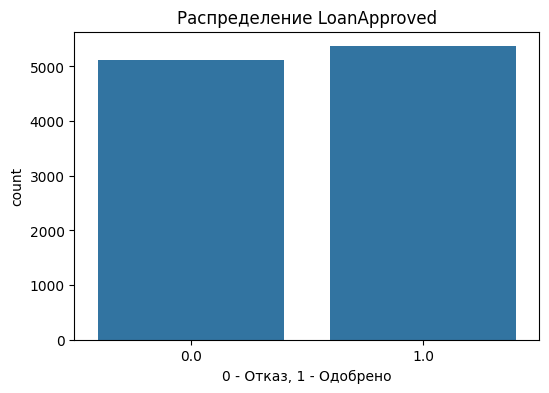

Доля положительного класса: 51.18%

Признаки с наибольшим количеством пропусков:
CreditScore            501
MonthlyDebtPayments    501
LoanAmount             501
NetWorth               501
BaseInterestRate       501
dtype: int64


In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title(f'Распределение {target_col}')
plt.xlabel('0 - Отказ, 1 - Одобрено')
plt.show()


print(f"Доля положительного класса: {y.mean():.2%}")

missing = X.isnull().sum().sort_values(ascending=False)
print("\nПризнаки с наибольшим количеством пропусков:")
print(missing[missing > 0].head())

In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_submission)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

print(f"Размерность X_processed: {X_processed.shape}")

Размерность X_processed: (10487, 52)


In [5]:
def get_confusion_stats(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

def custom_accuracy(y_true, y_pred):
    tp, tn, fp, fn = get_confusion_stats(y_true, y_pred)
    total = tp + tn + fp + fn
    return (tp + tn) / total if total > 0 else 0

def custom_precision(y_true, y_pred):
    tp, _, fp, _ = get_confusion_stats(y_true, y_pred)
    denominator = tp + fp
    return tp / denominator if denominator > 0 else 0

def custom_recall(y_true, y_pred):
    tp, _, _, fn = get_confusion_stats(y_true, y_pred)
    denominator = tp + fn
    return tp / denominator if denominator > 0 else 0

def custom_f1(y_true, y_pred):
    p = custom_precision(y_true, y_pred)
    r = custom_recall(y_true, y_pred)
    denominator = p + r
    return 2 * (p * r) / denominator if denominator > 0 else 0

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
preds = lr.predict(X_val)
probs = lr.predict_proba(X_val)[:, 1]

print(f"Custom Accuracy: {custom_accuracy(y_val, preds):.4f}")
print(f"Custom Precision: {custom_precision(y_val, preds):.4f}")
print(f"Custom Recall:    {custom_recall(y_val, preds):.4f}")
print(f"Custom F1:        {custom_f1(y_val, preds):.4f}")
print(f"Sklearn ROC-AUC:  {roc_auc_score(y_val, probs):.4f}")

Custom Accuracy: 0.9266
Custom Precision: 0.9323
Custom Recall:    0.9236
Custom F1:        0.9280
Sklearn ROC-AUC:  0.9819


In [6]:
class CustomBagging(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=42):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier(max_depth=5, random_state=random_state)
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []
        n_samples = X.shape[0]
        y_arr = np.array(y)
        
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y_arr[indices]
            
            model = clone(self.base_estimator)
            model.fit(X_boot, y_boot)
            self.models.append(model)
            
    def predict_proba(self, X):
        all_probas = np.array([model.predict_proba(X) for model in self.models])
        return np.mean(all_probas, axis=0)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

base_est = DecisionTreeClassifier(max_depth=5, random_state=42)
my_bag = CustomBagging(base_estimator=base_est, n_estimators=20, random_state=42)
my_bag.fit(X_train, y_train)
my_auc = roc_auc_score(y_val, my_bag.predict_proba(X_val)[:, 1])

sk_bag = BaggingClassifier(estimator=base_est, n_estimators=20, random_state=42, n_jobs=-1)
sk_bag.fit(X_train, y_train)
sk_auc = roc_auc_score(y_val, sk_bag.predict_proba(X_val)[:, 1])

print(f"Custom Bagging AUC: {my_auc:.4f}")
print(f"Sklearn Bagging AUC: {sk_auc:.4f}")

Custom Bagging AUC: 0.9744
Sklearn Bagging AUC: 0.9742


In [7]:
class CustomGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.initial_log_odds = 0.0
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        y = np.array(y)
        self.trees = []
        
        pos_frac = np.mean(y)
        pos_frac = np.clip(pos_frac, 1e-10, 1 - 1e-10)
        self.initial_log_odds = np.log(pos_frac / (1 - pos_frac))
        
        current_preds = np.full(len(y), self.initial_log_odds)
        
        for _ in range(self.n_estimators):
            probas = self._sigmoid(current_preds)
            residuals = y - probas
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)
            
            tree_pred = tree.predict(X)
            current_preds += self.learning_rate * tree_pred
            
            self.trees.append(tree)
            
    def predict_proba(self, X):
        log_odds = np.full(X.shape[0], self.initial_log_odds)
        
        for tree in self.trees:
            log_odds += self.learning_rate * tree.predict(X)
            
        probas = self._sigmoid(log_odds)
        return np.vstack([1 - probas, probas]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

my_gb = CustomGradientBoosting(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
my_gb.fit(X_train, y_train)
my_gb_auc = roc_auc_score(y_val, my_gb.predict_proba(X_val)[:, 1])

sk_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sk_gb.fit(X_train, y_train)
sk_gb_auc = roc_auc_score(y_val, sk_gb.predict_proba(X_val)[:, 1])

print(f"Custom GBM AUC: {my_gb_auc:.4f}")
print(f"Sklearn GBM AUC: {sk_gb_auc:.4f}")

Custom GBM AUC: 0.9729
Sklearn GBM AUC: 0.9790


In [8]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }
    
    clf = GradientBoostingClassifier(**params)
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = cross_val_score(clf, X_processed, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

print("Запуск оптимизации Optuna (20 итераций)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("\nЛучшие параметры:", study.best_params)
print("Лучший ROC-AUC (CV):", study.best_value)

[I 2025-12-08 17:11:14,161] A new study created in memory with name: no-name-9ac5676d-5a20-44f9-8d20-7a05cb9ef6a3


Запуск оптимизации Optuna (20 итераций)...


[I 2025-12-08 17:11:20,356] Trial 0 finished with value: 0.9830569048828356 and parameters: {'n_estimators': 257, 'learning_rate': 0.1210255712426133, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 17, 'subsample': 0.6125153146582613}. Best is trial 0 with value: 0.9830569048828356.
[I 2025-12-08 17:11:39,865] Trial 1 finished with value: 0.9833563171574372 and parameters: {'n_estimators': 225, 'learning_rate': 0.1241747596039051, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.7452484826937888}. Best is trial 1 with value: 0.9833563171574372.
[I 2025-12-08 17:12:13,773] Trial 2 finished with value: 0.9831094960586317 and parameters: {'n_estimators': 273, 'learning_rate': 0.06824860326243092, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9266831127990727}. Best is trial 1 with value: 0.9833563171574372.
[I 2025-12-08 17:12:25,528] Trial 3 finished with value: 0.9829688192764586 and parameters: {'n_estimators':


Лучшие параметры: {'n_estimators': 266, 'learning_rate': 0.07916712894668344, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 15, 'subsample': 0.7913459662112559}
Лучший ROC-AUC (CV): 0.984003976324178


In [9]:
best_params = study.best_params

final_model = GradientBoostingClassifier(**best_params, random_state=42)

final_model.fit(X_processed, y)

test_probs = final_model.predict_proba(X_test_processed)[:, 1]

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'LoanApproved': test_probs
})

output_file = 'submission_lab2.csv'
submission.to_csv(output_file, index=False)
print(f"Файл {output_file} успешно сохранен.")

Файл submission_lab2.csv успешно сохранен.
